<a href="https://colab.research.google.com/github/mel418/CECS456-Project/blob/main/vgg16_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import transforms, models
from PIL import Image
import os
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import time
from tqdm import tqdm

In [2]:
# Check GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')
if device.type == 'cuda':
    print(f'GPU: {torch.cuda.get_device_name(0)}')

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB


In [3]:
from google.colab import drive
drive.mount('/content/drive')

# go into folder for your project
%cd '/content/drive/MyDrive/CECS456_Project'

Mounted at /content/drive
/content/drive/MyDrive/CECS456_Project


In [4]:
class Animals10Dataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []

        # Class names (folders in the dataset)
        self.classes = [d for d in os.listdir(root_dir)
                       if os.path.isdir(os.path.join(root_dir, d))]
        self.classes.sort()

        print(f"Found classes: {self.classes}")

        # Load all images
        for idx, class_name in enumerate(self.classes):
            class_path = os.path.join(root_dir, class_name)
            for img_name in os.listdir(class_path):
                if img_name.lower().endswith(('.jpg', '.jpeg', '.png')):
                    self.image_paths.append(os.path.join(class_path, img_name))
                    self.labels.append(idx)

        print(f"Total images loaded: {len(self.image_paths)}")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
            label = self.labels[idx]

            if self.transform:
                image = self.transform(image)

            return image, label
        except Exception as e:
            print(f"Error loading {img_path}: {e}")
            # Return a black image if there's an error
            return torch.zeros(3, 224, 224), label

In [5]:
# Training transformations (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

# Validation/Test transformations (no augmentation)
val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])
])

In [6]:
# IMPORTANT: Update this path to match your dataset location
dataset_path = '/content/drive/MyDrive/CECS456_Project/raw-img'

# Create dataset
full_dataset = Animals10Dataset(root_dir=dataset_path, transform=train_transform)

# Split: 70% train, 15% validation, 15% test
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

# Split dataset
train_dataset, val_dataset, test_dataset = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(42)  # For reproducibility
)

# Update transforms for val and test
val_dataset.dataset.transform = val_test_transform
test_dataset.dataset.transform = val_test_transform

# Create dataloaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE,
                       shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                        shuffle=False, num_workers=2)

print(f"\n📊 Dataset Split:")
print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Batch size: {BATCH_SIZE}")

Found classes: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']
Total images loaded: 26179

📊 Dataset Split:
Training samples: 18325
Validation samples: 3926
Test samples: 3928
Batch size: 64


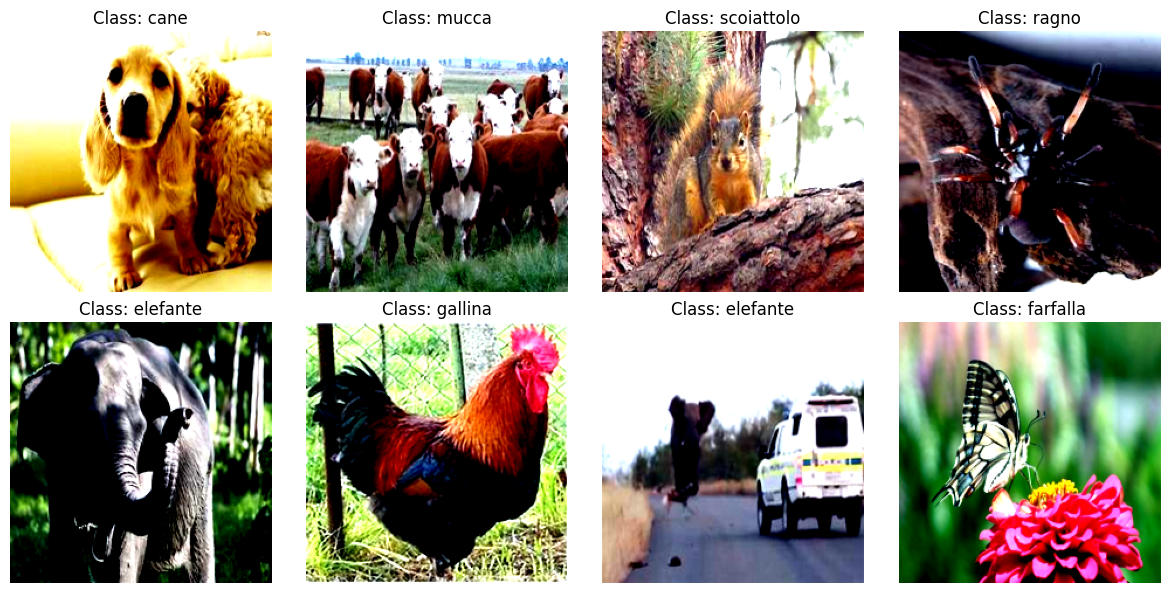

In [ ]:
# Visualize a few training images (optional)
def imshow(img, title):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.title(title)
    plt.axis('off')

# Get a batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
fig, axes = plt.subplots(2, 4, figsize=(12, 6))
for i, ax in enumerate(axes.flat):
    if i < len(images):
        imshow(images[i].cpu(),
               f"Class: {full_dataset.classes[labels[i]]}")
        plt.sca(ax)
plt.tight_layout()
plt.show()

In [7]:
class VGGModel(nn.Module):
    def __init__(self, num_classes=10, dropout=0.5):
        super(VGGModel, self).__init__()

        # Load pre-trained VGG16
        self.vgg = models.vgg16(pretrained=True)

        # Option 1: Freeze all convolutional layers (faster training)
        for param in self.vgg.features.parameters():
            param.requires_grad = False

        # Modify classifier for 10 classes
        self.vgg.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(p=dropout),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        return self.vgg(x)

# Create model
model = VGGModel(num_classes=10).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"🔧 Model Architecture: VGG16")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Frozen parameters: {total_params - trainable_params:,}")

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


100%|██████████| 528M/528M [00:02<00:00, 240MB/s]


🔧 Model Architecture: VGG16
Total parameters: 134,301,514
Trainable parameters: 119,586,826
Frozen parameters: 14,714,688


In [8]:
def train_one_epoch(model, loader, criterion, optimizer):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    pbar = tqdm(loader, desc='Training')
    for images, labels in pbar:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update progress bar
        pbar.set_postfix({'loss': f'{loss.item():.4f}',
                         'acc': f'{100.*correct/total:.2f}%'})

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in tqdm(loader, desc='Validation'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(loader)
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
# Training configuration
EPOCHS = 10
LEARNING_RATE = 0.001

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# For tracking
history = {
    'train_loss': [],
    'train_acc': [],
    'val_loss': [],
    'val_acc': []
}

print("🚀 Starting Training...")
print("=" * 60)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\nEpoch [{epoch+1}/{EPOCHS}]")

    # Train
    train_loss, train_acc = train_one_epoch(model, train_loader,
                                           criterion, optimizer)

    # Validate
    val_loss, val_acc = validate(model, val_loader, criterion)

    # Save history
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Print summary
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
    print("-" * 60)

end_time = time.time()
training_time = end_time - start_time

print(f"\n✅ Training Complete!")
print(f"Total training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

🚀 Starting Training...

Epoch [1/10]


Training:  67%|██████▋   | 191/287 [46:43<22:56, 14.34s/it, loss=0.5960, acc=86.81%]

In [ ]:
def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc='Testing'):
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    test_acc = 100 * correct / total
    return all_preds, all_labels, test_acc

print("🧪 Testing Model...")
predictions, true_labels, test_accuracy = test_model(model, test_loader)
print(f"\n📊 Test Accuracy: {test_accuracy:.2f}%")

🧪 Testing Model...


Testing:  14%|█▍        | 13/90 [02:20<13:50, 10.78s/it]


KeyboardInterrupt: 

In [ ]:
# Get class names
class_names = full_dataset.classes

# Create confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Plot
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names,
            cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)
plt.title('VGG16 - Confusion Matrix', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('vgg16_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

# Find most confused pairs
print("\n🔍 Most Confused Classes:")
for i in range(len(class_names)):
    for j in range(len(class_names)):
        if i != j and cm[i][j] > 5:  # Threshold of 5 misclassifications
            print(f"  {class_names[i]} → {class_names[j]}: {cm[i][j]} times")